In [101]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../../')
import set_plot_sizes

sys.path.append('../../../../cosmosis_wrappers/') # change to correct path
import ABC_saved_sims_multiparam

from tqdm import tqdm_notebook as tqdm

In [2]:
data_dir = './preloaded_data/ABC_results'

In [3]:
def load_ABC_results(modelversion):
    """
    Load the results of 10,000 simulations that have been fed through a trained network 
    and compared with some fiducial simulation
    """
    abc = dict()
    for key in ['summary', 'fisher', 'parameters', 'summaries', 'differences', 'distances', 'MLE']:
        abc[key] = np.load(f'./preloaded_data/ABC_results/abc{modelversion}{key}.npy')
    return abc

In [4]:
abc = load_ABC_results(modelversion=3)

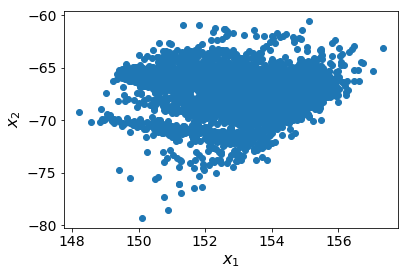

In [8]:
plt.scatter(abc['summaries'][:,0],abc['summaries'][:,1]);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');
plt.show()

In [9]:
print (np.corrcoef(abc['summaries'],rowvar=False))

[[ 1.        -0.2900731]
 [-0.2900731  1.       ]]


#### The variables seem negatively correlated quite significantly. Also note the one weird region: (the lower stripe)

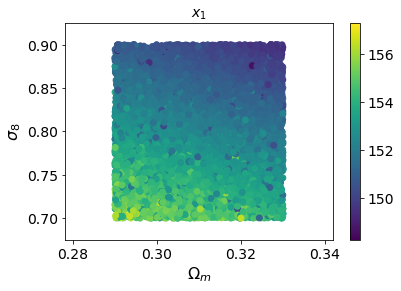

In [12]:
num = 10000 # number of points to plot
plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,0]);
plt.title("$x_1$")
plt.colorbar()
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.show()

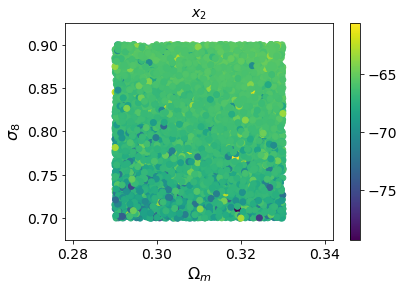

In [13]:
plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,1]);
plt.title("$x_2$")
plt.colorbar()
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.show()

#### $x_1$ seems to be easier to fit with a plane than $x_2$, we shall start with $x_1 = a\Omega_m + b\sigma_8$.

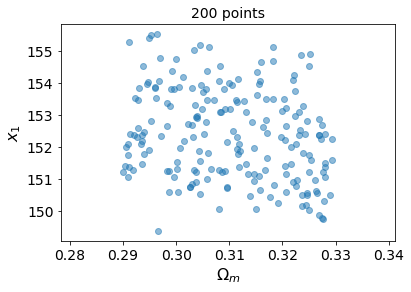

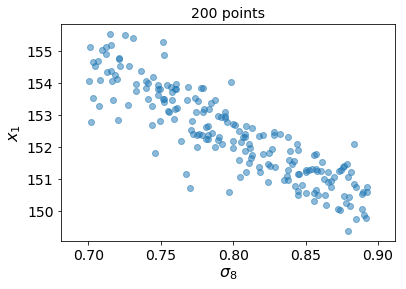

In [70]:
# num = 1000
# plt.title(f"{num} points")
# plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,0],alpha=0.5)
# plt.xlabel('$\Omega_m$');
# plt.ylabel('$x_1$')
# plt.show()

# plt.title(f"{num} points")
# plt.scatter(abc['parameters'][:num,1], abc['summaries'][:num,0],alpha=0.5)
# plt.xlabel('$\sigma_8$');
# plt.ylabel('$x_1$')
# plt.show()

num = 200
plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,0],alpha=0.5)
plt.xlabel('$\Omega_m$');
plt.ylabel('$x_1$')
plt.show()

plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,1], abc['summaries'][:num,0],alpha=0.5)
plt.xlabel('$\sigma_8$');
plt.ylabel('$x_1$')
plt.show()

In [26]:
def linleastsquares(X, y):
    """
    Fit linear least squares, given a matrix X
    X = shape (observations,num_params) (1000,2)
    y = observed data values -- shape = (1000,)
    
    returns beta -- best fit parameters -- shape (2,)
    """
    beta = np.dot((np.dot( np.linalg.inv(np.dot(X.T,X)), X.T)),y)   
    return beta

In [119]:
def plot_fit_result(model,xindx):
    """
    Plot a few images to show how well the model fits the data
    
    model -- function: the best fit model, should take two parameters: Omega_m and sigma_8
    xindx -- integer:  1 for fitting x1. 2 for fitting x2
    
    """
    # Calculate values according to the model
    omega_m = np.linspace(0.28,0.34,30)
    sigma_8 = np.linspace(0.70,0.90,30)
    xv, yv = np.meshgrid(omega_m, sigma_8)
    model_sol = model(xv,yv)

    plt.contourf(omega_m,sigma_8, model_sol);
    plt.title(f"Fit to $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()

    # color boundaries hardcoded
    if xindx == 1:
        vmin = 149
        vmax = 157
    if xindx == 2:
        vmin = -79
        vmax = -61
    
    num = 1000
    model_sol_scatter = model(abc['parameters'][:num,0],abc['parameters'][:num,1])
    plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1], c=model_sol_scatter
                ,vmin=vmin,vmax=vmax);
    plt.title(f"Fit to $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()

    plt.scatter(abc['parameters'][:num,0],abc['parameters'][:num,1],c=abc['summaries'][:num,xindx-1]
                ,vmin=vmin,vmax=vmax);
    plt.title(f"Actual $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()
    
def plot_fit_result1D(model,xindx):
    """
    Plot a few images in 1D to show how well the model fits the data
    
    model -- function: the best fit model, should take two parameters: Omega_m and sigma_8
    xindx -- integer:  1 for fitting x1. 2 for fitting x2
    
    """
    num = 1000
    model_sol_scatter = model(abc['parameters'][:num,0],abc['parameters'][:num,1])
    plt.title(f"{num} points")
    plt.scatter(abc['parameters'][:num,0], model_sol_scatter,alpha=0.5)
    plt.xlabel('$\Omega_m$');
    plt.ylabel(f'$x_{xindx}$')
    plt.show()

    plt.title(f"{num} points")
    plt.scatter(abc['parameters'][:num,1], model_sol_scatter,alpha=0.5)
    plt.xlabel('$\sigma_8$');
    plt.ylabel(f'$x_{xindx}$')
    plt.show()

In [81]:
# Fit to 200 points
num = 200
# Fit x1 = a\Omega_m + b\sigma_8 + c
X = np.array([abc['parameters'][:num,0], abc['parameters'][:num,1], np.ones(num)]).T # (1000,3)
y = abc['summaries'][:num,0] # x1

ahat, bhat, chat = linleastsquares(X,y)
print (ahat,bhat, chat)

-34.111706898950274 -22.986691736333057 181.33919959986176


In [82]:
model = lambda x, y: ahat*x + bhat*y + chat

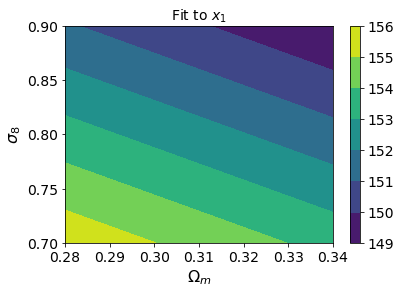

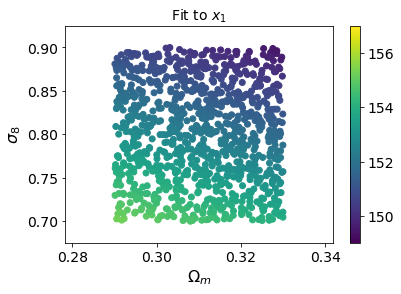

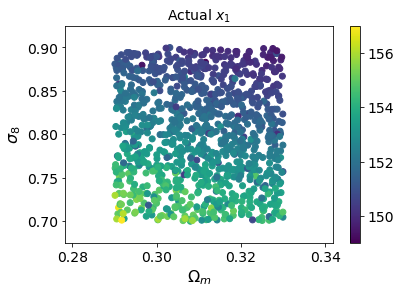

In [83]:
plot_fit_result(model,xindx=1)

#### Imo the fit looks quite good.

In [73]:
# Fit to x2, same procedure

num = 200
# Fit x1 = a\Omega_m + b\sigma_8 + c
X = np.array([abc['parameters'][:num,0], abc['parameters'][:num,1], np.ones(num)]).T # (1000,3)
y2 = abc['summaries'][:num,1] # x2

ahat2, bhat2, chat2 = linleastsquares(X,y2)
print (ahat2,bhat2, chat2)

24.693852408845373 14.539551951223899 -86.13434701648762


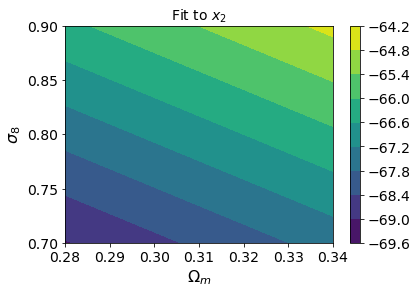

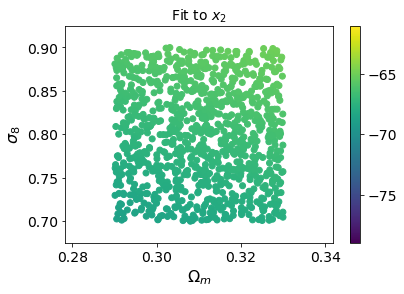

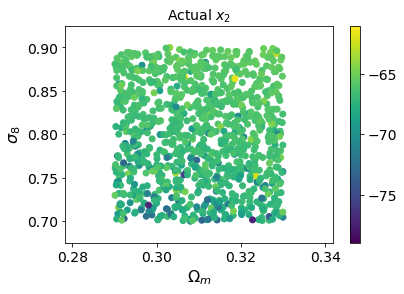

In [84]:
model2 = lambda x, y: ahat2*x + bhat2*y + chat2
plot_fit_result(model2,xindx=2)

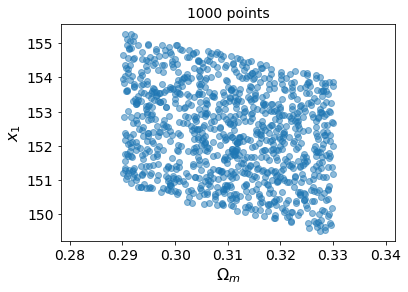

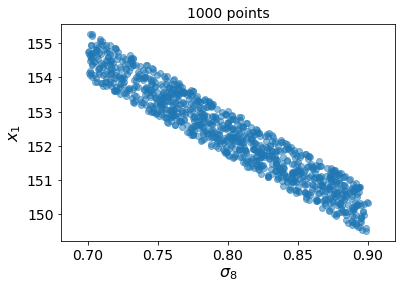

In [118]:
# Now in 1D:
plot_fit_result1D(model,xindx=1)

#### Now perform ABC with the function that generates x1 and x2, no cosmosis needed.

In [91]:
import tensorflow as tf
# change to the path where the IMNN git clone is located
# new version of IMNN by Tom
sys.path.insert(-1,'../../../../../IMNNv2/IMNN/')
import IMNN.ABC.priors as priors

In [86]:
def output_summaries(theta,model1,model2):
    """
    Return x1,x2 for a given theta = list of [Omega_m, sigma_8]'s' 
    given the two fitted models to x1 x2
    """
    theta = np.array(theta)
    Omega_m = theta[:,0]
    sigma_8 = theta[:,1]
    x1 = model1(Omega_m,sigma_8)
    x2 = model2(Omega_m,sigma_8)
    
    return np.array([x1,x2]).T # return as array of shape (len(theta),2)

In [147]:
def ABC_with_model(draws, real_summary, prior, model1, model2, fisher):

    Gaussprior = priors.TruncatedGaussian(prior["mean"],prior["variance"],prior["lower"]
                                    ,prior["upper"])
    # Draw params from Gaussian prior
    theta = Gaussprior.draw(draws)
    # Calculate summaries with models
    summaries = output_summaries(theta, model1,model2)
    # Calculate distance
    differences = summaries - real_summary
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    ABC_dict = dict()
    ABC_dict["summary"] = real_summary
    ABC_dict["fisher"] = fisher
    ABC_dict["parameters"] = theta
    ABC_dict["summaries"] = summaries
    ABC_dict["differences"] = differences
    ABC_dict["distances"] = distances
    
    return ABC_dict
    

In [148]:
# Variables for ABC
draws = int(1e5) # amount of draws
fisher = abc['fisher'] # fisher info
real_summary = abc['summary'] # summary of 'real' data
# A Truncated gaussian prior
prior = {'mean': np.array([0.30,0.805]),
         'variance': np.array([[0.01,0],[0,0.01]]), # cov matrix
         'lower': np.array([0.27,0.69]),
         'upper': np.array([0.34,0.91]) 
         }

In [149]:
abc_model = ABC_with_model(draws, real_summary, prior, model, model2, fisher)

Epsilon is chosen to be 70.00
Number of accepted samples =  8133


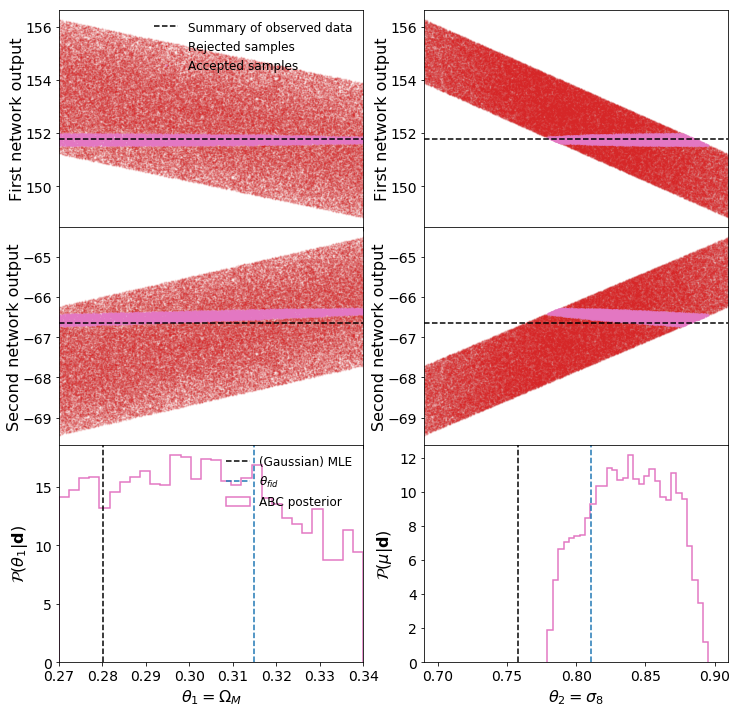

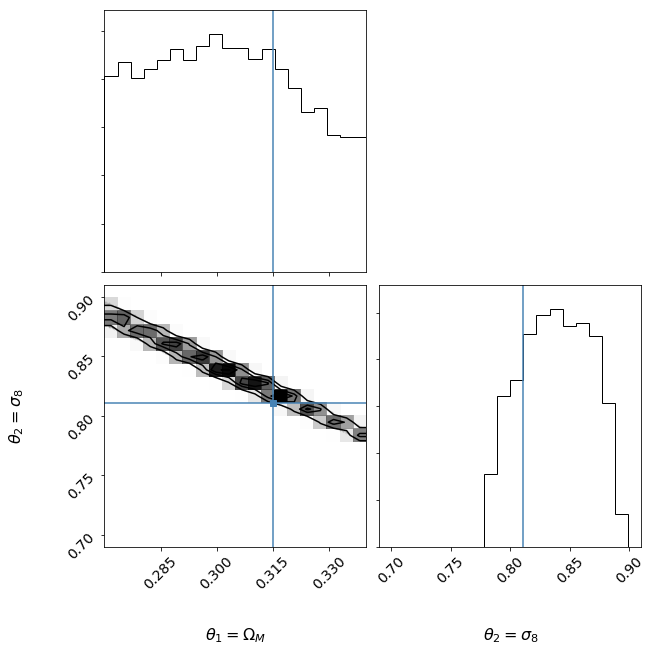

In [112]:
class holder(object):
    """Small class because plotting function requires it"""
    def __init__(self,saveversion,figuredir):
        self.modelversion = saveversion
        self.figuredir = figuredir
        

holder1 = holder(saveversion=3,figuredir='./')
theta_fid = np.array([0.315, 0.811])
# plotting function requires this too, does not depend on model fitting though, so steal from earlier abc
abc_model["MLE"] = abc["MLE"]
ABC_saved_sims_multiparam.plot_ABC_2params(abc_model, holder1, theta_fid, prior, oneD='both'
                                           , hbins=30, epsilon=70,show=True)


In [110]:
from importlib import reload

In [121]:
reload(ABC_saved_sims_multiparam)

<module 'ABC_saved_sims_multiparam' from '../../../../cosmosis_wrappers/ABC_saved_sims_multiparam.py'>

#### What if we just fit a line to a summmary as a function of $\Omega_m$ and as function of $\sigma_8$ seperately? Essentially that is saying 
\begin{equation}
\vec{x} (\Omega_m,\sigma_8) => \vec{x} (\Omega_m),\vec{x} (\sigma_8)
\end{equation}

In [132]:
# Fit to 200 points
num = 200
# Fit x1 = a11\Omega_m + b11
X = np.array([abc['parameters'][:num,0], np.ones(num)]).T # (1000,2)
y = abc['summaries'][:num,0] # x1

a11hat, b11hat = linleastsquares(X,y)
print (a11hat,b11hat)

# and x2 = a21\Omega_m + b21
X = np.array([abc['parameters'][:num,0], np.ones(num)]).T # (1000,2)
y = abc['summaries'][:num,1] # x2
a21hat, b21hat = linleastsquares(X,y)
print (a21hat,b21hat)

-29.23570211919457 161.46084249888997
21.609679809200884 -73.56088019969843


In [133]:
# x1 as function of Omega_M
model11 = lambda x: a11hat*x+b11hat
# x2 as function of Omega_M
model21 = lambda x: a21hat*x+b21hat

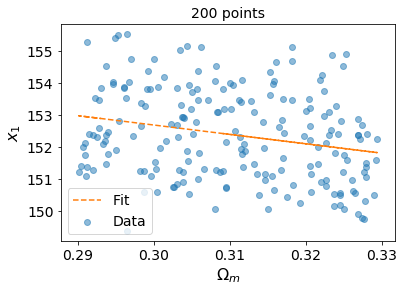

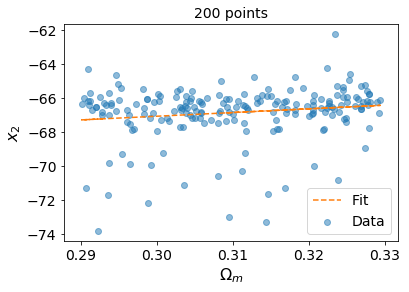

In [135]:
num = 200
plt.plot(abc['parameters'][:num,0], model11(abc['parameters'][:num,0]),label='Fit',ls='dashed',c='C1')
plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,0],alpha=0.5,label='Data')
plt.xlabel('$\Omega_m$');
plt.ylabel('$x_1$')
plt.legend()
plt.show()

plt.plot(abc['parameters'][:num,0], model21(abc['parameters'][:num,0]),label='Fit',ls='dashed',c='C1')
plt.title(f"{num} points")
plt.scatter(abc['parameters'][:num,0], abc['summaries'][:num,1],alpha=0.5,label='Data')
plt.xlabel('$\Omega_m$');
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [189]:
def output_summaries1D(theta,model1,model2):
    """
    Return x1,x2 for a given theta = list of [Omega_m]'s' 
    given the two fitted models to x1 x2
    """
    theta = np.array(theta)
    Omega_m = theta[:,0]
    x1 = model1(Omega_m)
    x2 = model2(Omega_m)
    
    return np.array([x1,x2]).T # return as array of shape (len(theta),2)

def ABC_with_model1D(draws, real_summary, prior, model1, model2, fisher):
    """
    Only as a function of Omega_m
    """
    
    Gaussprior = priors.TruncatedGaussian(prior["mean"],prior["variance"],prior["lower"]
                                    ,prior["upper"])
    # Draw params from Gaussian prior
    theta = Gaussprior.draw(draws)
    # Calculate summaries with models
    summaries = output_summaries1D(theta, model1,model2)
    # Calculate distance
    differences = summaries - real_summary
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    
    ABC_dict = dict()
    ABC_dict["summary"] = real_summary
    ABC_dict["fisher"] = fisher
    ABC_dict["parameters"] = theta
    ABC_dict["summaries"] = summaries
    ABC_dict["differences"] = differences
    ABC_dict["distances"] = distances
    
    return ABC_dict


In [190]:
# Variables for ABC
draws = int(1e5) # amount of draws
fisher = abc['fisher'] # fisher info
real_summary = abc['summary'] # summary of 'real' data
# A Truncated gaussian prior
prior = {'mean': np.array([0.30]),
         'variance': np.array([[0.01]]), # 1x1 covariance matrix
         'lower': np.array([0.27]),
         'upper': np.array([0.34]) 
         }

In [191]:
# Plot results 
def plot_1D(ABC_dict, prior, epsilon=None,analytic_posterior = None, param_array = None):
    """
    As function of omega_m only
    """
    
    if epsilon is None: epsilon = np.linalg.norm(abc["summary"])/2. # chosen quite arbitrarily
    accept_indices = np.argwhere(ABC_dict["distances"] < epsilon)[:, 0]
    reject_indices = np.argwhere(ABC_dict["distances"] >= epsilon)[:, 0]

    print ('Epsilon is chosen to be %.2f'%epsilon)
    print("Number of accepted samples = ", accept_indices.shape[0])

    truths = theta_fid
    
    fig, ax = plt.subplots(3, 1, sharex = 'col', figsize = (10, 10))
    plt.subplots_adjust(hspace = 0)

    # Plot the accepted/rejected samples
    ax[0].scatter(ABC_dict["parameters"][reject_indices] # Omega_m
        , ABC_dict["summaries"][reject_indices,0] # x1
        , s = 1, alpha = 0.1, label = "Rejected samples", color = "C3") 

    ax[0].scatter(ABC_dict["parameters"][accept_indices]
     , ABC_dict["summaries"][accept_indices,0]
     , s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)

    ax[0].axhline(abc["summary"][0,0]
        , color = 'black', linestyle = 'dashed', label = "Summary of observed data")

    ax[0].legend(frameon=False)
    ax[0].set_ylabel('First network output', labelpad = 0)
    ax[0].set_xlim([prior["lower"][0], prior["upper"][0]])
    # ax[0].set_xticks([])

    # Plot the accepted/rejected samples
    ax[1].scatter(ABC_dict["parameters"][reject_indices] # Omega_m
        , ABC_dict["summaries"][reject_indices,1] # x2
        , s = 1, alpha = 0.1, label = "Rejected samples", color = "C3") 

    ax[1].scatter(ABC_dict["parameters"][accept_indices]
     , ABC_dict["summaries"][accept_indices,1] # x2
     , s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)

    ax[1].axhline(abc["summary"][0,1]
        , color = 'black', linestyle = 'dashed', label = "Summary of observed data")

    ax[1].set_ylabel('Second network output', labelpad = 0)
    
    # plot the posterior
    ax[2].hist(ABC_dict["parameters"][accept_indices], bins=20, histtype = u'step', density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
    ax[2].axvline(abc["MLE"][0,0], linestyle = "dashed", color = "black", label = "(Gaussian) MLE")
    ax[2].set_xlim([prior["lower"][0], prior["upper"][0]])
    ax[2].set_ylabel('$\\mathcal{P}(\\theta_1|{\\bf d})$')
    # ax[2].set_yticks([])
    # ax[2].set_xticks([])|
    ax[2].set_xlabel(r"$\theta_1 = \Omega_M$")

    # Theta-fid
    ax[2].axvline(theta_fid[0], linestyle = "dashed", label = "$\\theta_{fid}$")

    if analytic_posterior is not None:
        ax[2].plot(param_array, analytic_posterior, linewidth = 1.5, color = 'C2'
            , label = "Analytic posterior")


    ax[2].legend(frameon = False)


    fig.suptitle(f"Epsilon = {epsilon}")

    plt.savefig(f'./TEST.png')
    plt.show()

Epsilon is chosen to be 60.00
Number of accepted samples =  6502


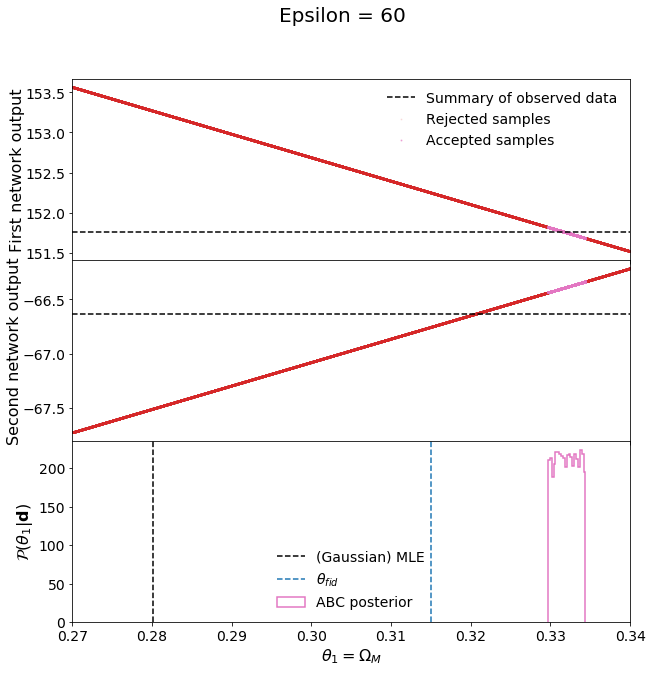

In [192]:
abc_model1D = ABC_with_model1D(draws, real_summary, prior, model11, model21, fisher)
abc_model1D["MLE"] = abc["MLE"][:,0] # only 1st param
plot_1D(abc_model1D, prior, epsilon=60,analytic_posterior = None, param_array = None)